In [73]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [74]:
import numpy as np
import pandas as pd

In [75]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [76]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [77]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [78]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [79]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [80]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [81]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [82]:

cols = session.query(Measurement).first()

cols.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x207a1755160>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [83]:
cols2 = session.query(Station).first()
cols2.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x207a1755d30>,
 'longitude': -157.8168,
 'id': 1,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'latitude': 21.2716}

# Exploratory Climate Analysis

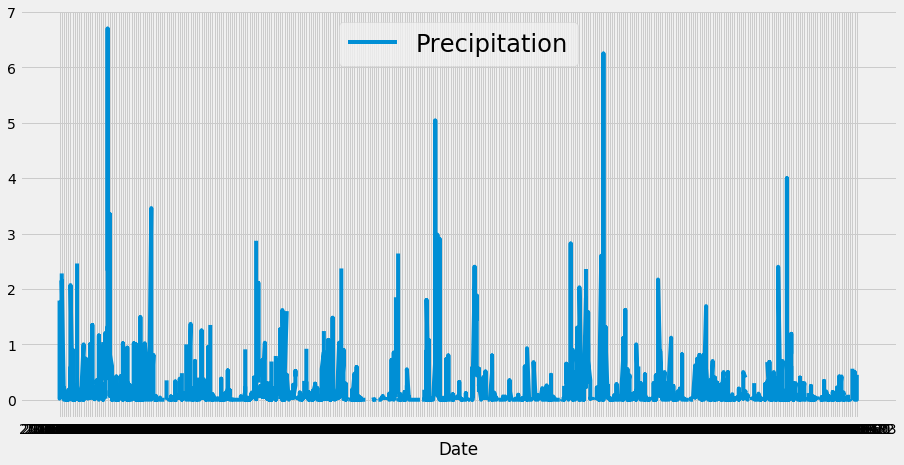

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).all()
end = last_date[0][0]
start = last_date[0][0].replace('7','6')


# Perform a query to retrieve the data and precipitation scores
Precip_data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>= start ).\
filter(Measurement.date <= end).statement
Precip_df = pd.read_sql_query(Precip_data,session.bind)

Precip_df.set_index(['date'],inplace = True)
Precip_df.sort_index(inplace = True)
Precip_df.head()
plt.figure(figsize = (14,7))
x = Precip_df.index
y = Precip_df.prcp

plt.xlabel('Date')

plt.plot(x,y,label = 'Precipitation')
plt.legend(loc = 9,fontsize = 'xx-large') 
plt.savefig('precitp.png')
plt.show()

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [85]:
replace = last_date[0][0].replace("7","6")
replace

'2016-08-23'

![precipitation](Images/precipitation.png)

In [86]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [87]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.station)).all() 
station_count[0][0]

9

In [88]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [89]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_station_stats = session.query(Measurement.station,func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
filter(Measurement.station ==active_stations[0][0]).all()
active_station_stats

[('USC00519281', 54.0, 71.66378066378067, 85.0)]

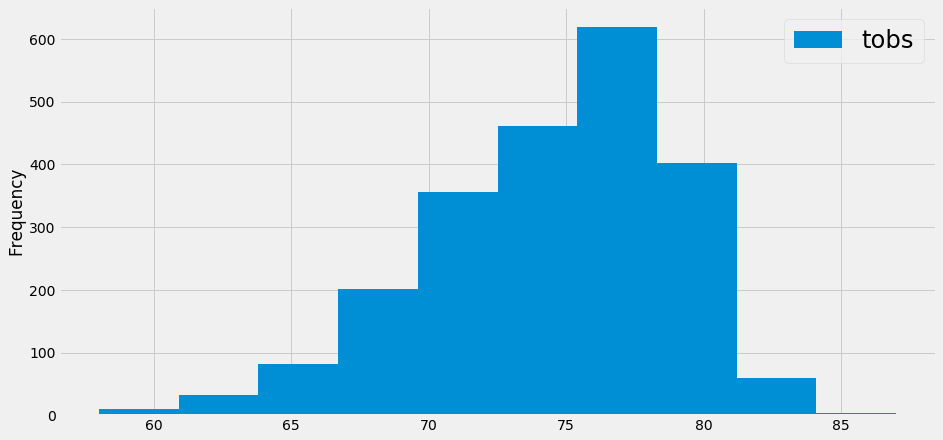

In [90]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = session.query(func.max(Measurement.date)).all()
end = last_date[0][0]
start = last_date[0][0].replace('7','6')
active_station_temps = session.query(Measurement.tobs).filter(Measurement.date>= start).filter(Measurement.date<=end).all()

my_list = []
for i in range(0,len(active_station_temps)):
    x = active_station_temps[i][0]
    my_list.append(x)
plt.figure(figsize =[14,7])
plt.hist(my_list,label = 'tobs')
plt.ylabel('Frequency')
plt.legend(fontsize = 'xx-large')
plt.savefig('Temp.png')
plt.show()
    


In [91]:
active_station_temps[0]

(81.0)

![precipitation](Images/station-histogram.png)

In [92]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [93]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2017-06-05','2017-06-15')
my_trip[0]

(72.0, 77.21917808219177, 83.0)

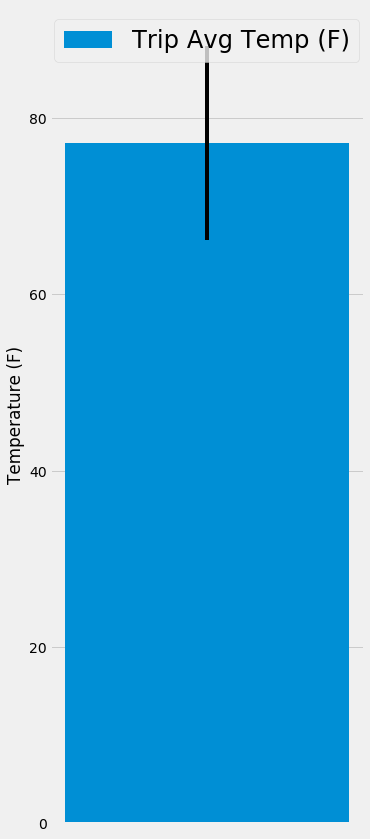

In [94]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize = [5,14])
x =1
y = round(my_trip[0][1],2)
error = my_trip[0][2] - my_trip[0][0]
plt.ylabel('Temperature (F)')
plt.bar(x,height = y,yerr = error,label = 'Trip Avg Temp (F)')
plt.legend(loc = 9,fontsize = 'xx-large')
plt.xticks([])
plt.savefig('Trip.png')
plt.show()

In [95]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start = '2016-06-05'
end = '2016-06-15'
sel = (Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp))
rain_trip = session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date>= start).\
filter(Measurement.date <= end).group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()

rain_trip


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  7.69),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.3100000000000005),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  2.0400000000000005),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.23),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.71),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.09),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.02)]

## Optional Challenge Assignment

In [96]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).group_by(Measurement.date).all()
    
daily_normals("01-01")

[(65.0, 69.71428571428571, 75.0),
 (69.0, 72.14285714285714, 77.0),
 (63.0, 68.42857142857143, 71.0),
 (69.0, 70.5, 72.0),
 (65.0, 68.66666666666667, 75.0),
 (63.0, 66.28571428571429, 71.0),
 (62.0, 68.16666666666667, 74.0),
 (62.0, 69.33333333333333, 74.0)]

In [97]:
def starts(start):
   
    TMIN = func.min(Measurement.tobs)
    TAVG = func.min(Measurement.tobs)
    TMAX = func.min(Measurement.tobs)
    starts = session.query(TMIN,TAVG,TMAX,Measurement.date).\
    filter(func.strftime('%Y-%m-%d',Measurement.date)>= start).group_by(Measurement.date).all()
    start_list =[]
    for x in starts:
        start_dict = {}
        start_dict['TMIN'] = x[0]
        start_dict['TAVG'] = x[1]
        start_dict['TMAX'] = x[2]
        start_dict['DATE'] = x[3]
        start_list.append(start_dict)
    return start_list

In [ ]:
starts('2015-07-27')

In [98]:
#start = dt.datetime(2015,6,22)
TMIN = func.min(Measurement.tobs)
TAVG = func.avg(Measurement.tobs)
TMAX = func.max(Measurement.tobs)
starts = session.query(TMIN,TAVG,TMAX,Measurement.date).\
filter(func.strftime('%Y-%m-%d',Measurement.date)>=start).group_by(Measurement.date).all()
starts[1][0]

72.0

In [99]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

"""Since this is optional I'm not going to do it as described.. seems to be the hard way"""

trip_start = dt.datetime(2019,6,5)
trip_end = dt.datetime(2019,6,15)
start = '06-05'
end = '06-15'
 
sel = [func.strftime("%m-%d",Measurement.date),func.min(Measurement.tobs),func.round(func.avg(Measurement.tobs),2),\
       func.max(Measurement.tobs)]
trip_normals = session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) >= start).\
filter(func.strftime("%m-%d",Measurement.date)<= end).group_by(func.strftime("%m-%d",Measurement.date)).statement

    

In [184]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.read_sql_query(trip_normals,session.bind)
trip_df.rename(columns = {'strftime_1':'Date','min_1':'Low_Temp','round_1':'Avg_Temp','max_1':'High_Temp'},inplace = True)



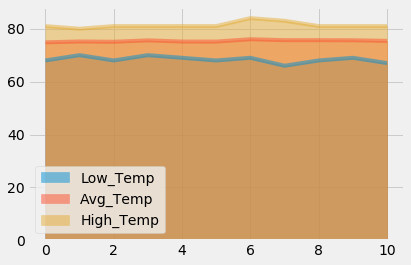

In [185]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked = False,)

'06-05'